# Optimization Framework using auto-diff to predict binding rates


## Import the necessary modules

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../")
import copy
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

## Setup Reaction Network
#### Read the corresponding input file and call the ReactionNetwork class

In [2]:
base_input = './trimer_homorates.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['default_assoc', 1.0]
['homo_rates', True]
New node added - Node index: 3 ; Node label: AB 
New node added - Node index: 4 ; Node label: AC 
Trying internal bonds
New node added - Node index: 5 ; Node label: BC 
New node added - Node index: 6 ; Node label: ABC 
Trying internal bonds
Trying internal bonds
Trying internal bonds
Trying internal bonds
Trying internal bonds
Trying internal bonds
Reaction Network Completed


## Checking reaction network
Looping over all network nodes to check if all species are created
Creating a dictionary for later reference. This dictionary holds the reactants as keys and values as the reaction index

In [3]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n,"--",gtostr(rn.network.nodes[n]['struct']))
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

0 -- A
1 -- B
2 -- C
3 -- AB
4 -- AC
5 -- BC
6 -- ABC
{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


## Set the initial parameter values 
For a hetero-trimer there are 6 reaction rates.
Also defines the Vectorized Rxn NEt class

In [4]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
new_kon = new_kon + Tensor([1])

update_kon_dict = {}
for edge in rn.network.edges:
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))


vec_rn = VectorizedRxnNet(rn, dev='cpu')
print(vec_rn.kon)

{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 5}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 3}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None,

In [5]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
B
C
AB
AC
BC
ABC
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B'}), 'kon': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'score': tensor([-20.], dtype=torch.float64), 'koff': None, 'uid': 0}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C'}), 'kon': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'score': tensor([-20.], dtype=torch.float64), 'koff': None, 'uid': 1}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C'}), 'kon': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'score': tensor([-20.], dtype=torch.float64), 'koff': None, 'uid': 2}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'A', 'C'}), 'kon': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'score': tensor([-40.], dtype=torch.float64), 'koff': None, 'uid': 3}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'C'}, 

## Using the optimizer ##

### Define an instance of the optimizer class
#### Input Arguments:

reaction_network : Input the vectorized rxn network

sim_runtime: The runtime of the kinetic simulation. Needs to be same as the time over the experimental reaction data.

optim_iterations: No. of iterations to run the optimization. Can start at low values(100) and increase depending upon memory usage.

learning_rate = The size of the gradient descent step for updating parameter values. Needs to be atleast (1e-3-1e-1)* min{parameter value}. If learning rate is too high, it can take a longer step and sometimes lead to negative value of parameters which is unphysical. Requires some trial runs to find the best value. 

device: cpu or gpu

method: Choose which pytorch based optimized to use for gradient descent - Adam or RMSprop

mom: Only for RMSprop method. Use momentum term during gradient descent. 


In [6]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=100,
                  learning_rate=1e-2,
                  device='cpu',method="RMSprop")


### Call the optimization method

#### Input arguments

conc_scale, conc_thresh, mod_bool, mod_factor = As defined for the VecSim class. 

max_thresh: Max. allowed values of parameters being updated. Beyond this maximum a penalty is imposed on the cost function. (Regularization)

max_yield: It is a control variable that is used to store the updated parameter values over all iterations for further analysis. The parameter values are stored only if the current yield exceed this max_yield. 

yield_species: Yield of the species being optimized(node index)

In [7]:
optim.rn.update_reaction_net(rn)
optim.optimize(conc_scale=1e-1,conc_thresh=1e-1,mod_bool=True,mod_factor=10,max_thresh=1e8,max_yield=0,yield_species=-1)

Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 1.], dtype=torch.float64, requires_grad=True)]
Optimizer State: <bound method Optimizer.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)>
Using CPU
Yield on sim. iteration 0 was 67.4%.
current params: tensor([1., 1.], dtype=torch.float64)
tensor(0.6742, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim. iteration 1 was 72.5%.
current params: tensor([0.9000, 1.1000], dtype=torch.float64)
tensor(0.7258, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim. iteration 2 was 75.9%.
current params: tensor([0.8316, 1.1609], dtype=torch.float64)
tensor(0.7595, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim. iteration 3 was 78.2%.
current params: tensor([0.7832, 1.2007], dtype=torch.float64)
tensor(0.7830, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim

## Track the yield over optim iterations

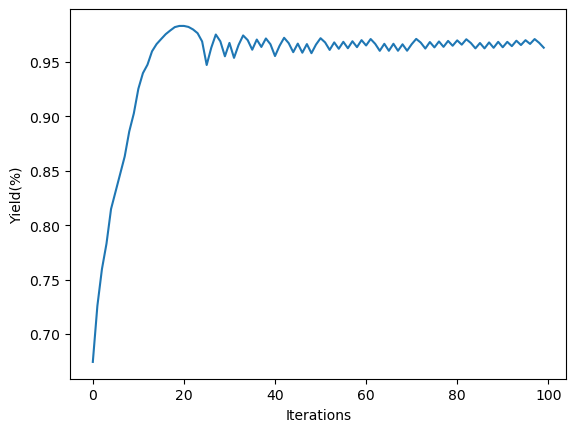

In [8]:
optim.plot_yield()

## Get all the parameter values

### This can be stored in a file for later analysis or used to find the best parameter value depending upon a condition. For e.g. the values that give a minimum error.

In [9]:
yields= []
final_params=[]

final_t50 = []
final_t85 = []
final_t95 = []
final_t99 = []

for i in range(len(optim.final_yields)):
    yields.append(optim.final_yields[i])
    final_params.append(optim.final_solns[i])
    
    #Storing the different time points it reaches a particular yield threshold
    if optim.final_t85[i] == -1:
        final_t85.append(1) 
    else:
        final_t85.append(optim.final_t85[i]) 
    if optim.final_t95[i] == -1:
        final_t95.append(1)
    else:
        final_t95.append(optim.final_t95[i])

final_yield_arr = np.array(yields)
final_param_arr = np.array(final_params)
final_t85 = np.array(final_t85)
final_t95 = np.array(final_t95)

### Plotting the ratio of ktri vs kdim

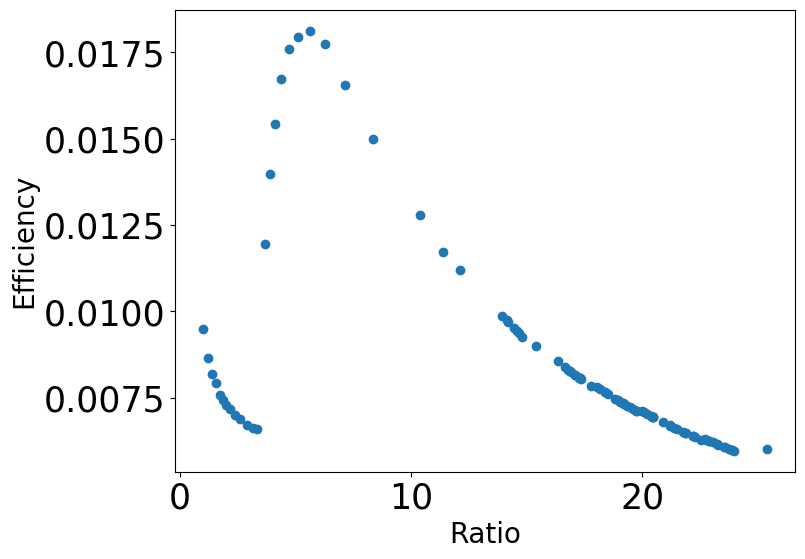

In [10]:
import matplotlib.pyplot as plt

mask_r = final_yield_arr > 0.5

#Calculate the ratio
ratio = final_param_arr[:,1]/final_param_arr[:,0]

#Normalize the time scale (t = t*conc*max_rate)
conc=vec_rn.initial_copies[0].item()
scale_time = final_t95[mask_r]*conc*np.max(final_param_arr[mask_r],axis=1)
#Calculate the y_per_time
y_per_time = 0.95/scale_time

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(ratio,y_per_time,linestyle='',marker='o')
ax.set_ylabel("Efficiency",fontsize=20)
ax.set_xlabel("Ratio",fontsize=20)
ax.tick_params(labelsize=25)


In [11]:
min_indx = np.argmax(y_per_time)
print("Ratio with maximum efficiency: ",ratio[min_indx])

Ratio with maximum efficiency:  5.6089283096520335
